# League of Legends Early Objectives

## Imports

In [178]:
%matplotlib inline

from functools import partial
from json import load
from os import listdir, remove
from os.path import expanduser, isfile, join
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import clear_output, display

## Define Features

In [44]:
def _extract_indicator_from_teams(key: str, match_details: dict) -> int:
    indicator = 0
    for team in match_details['teams']:
        if team['teamId'] == 100:
            indicator -= team[key]
        else:
            indicator += team[key]
    return indicator

def _extract_participant_stat(aggregator: callable, key: str, match_details: dict) -> int:
    blue = aggregator(
        participant['stats'][key] if key in participant['stats'] else 0
        for participant in match_details['participants']
        if participant['teamId'] == 100)

    red = aggregator(
        participant['stats'][key] if key in participant['stats'] else 0
        for participant in match_details['participants']
        if participant['teamId'] == 200)
    
    return red-blue

def extract_red_win(match_details: dict) -> bool:
    team = match_details['teams'][0]
    
    if team['teamId'] == 100:  # blue
        if team['win'] == 'Win':
            return False
        else:
            return True
    else:  # red
        if team['win'] == 'Win':
            return True
        else:
            return False

features = (
    ('redWin', 'i1', extract_red_win),
    ('firstDragon', 'i1', partial(_extract_indicator_from_teams, 'firstDragon')),
    ('firstRiftHerald', 'i1', partial(_extract_indicator_from_teams, 'firstRiftHerald')),
    ('firstBlood', 'i1', partial(_extract_indicator_from_teams, 'firstBlood')),
    ('firstTower', 'i1', partial(_extract_indicator_from_teams, 'firstTower')),
    ('anyFirstBloodAssist', 'i1', partial(_extract_participant_stat, any, 'firstBloodAssist')),
    ('anyFirstTowerAssist', 'i1', partial(_extract_participant_stat, any, 'firstTowerAssist')),
    ('sumFirstBloodAssist', 'i1', partial(_extract_participant_stat, sum, 'firstBloodAssist')),
    ('sumFirstTowerAssist', 'i1', partial(_extract_participant_stat, sum, 'firstTowerAssist'))
)

## Loading Data

The data is in a folder with one file per match. The files are JSON encoded and named `{matchID}.json`.

In [102]:
base_path = join(expanduser('~'), 'Downloads', 'lol_matches')

filelist = listdir(base_path)

data = np.zeros(len(filelist), dtype=[(f, t) for f, t, _ in features])
data[:] = -128

print(f"loading max. {len(filelist)} files")

def load_and_parse_match_details(data: pd.DataFrame, file_i: int, base_path: str, file_name: str):
    file_path = join(base_path, file_name)

    if isfile(file_path):
        with open(file_path, 'r') as match_file:
            match_details = load(match_file)
            
        if not match_details['queueId'] in (420, 440):
            remove(file_path)
        else:
            for feature, _, extractor in features:
                data[feature][file_i] = extractor(match_details)
                
    return file_i

max_file_done = 0

with ThreadPoolExecutor() as executor:

    futures = tuple(
        executor.submit(load_and_parse_match_details, data, file_i, base_path, file_name)
        for file_i, file_name in enumerate(filelist)
        if file_name.endswith('.json')
    )
    
    for future in as_completed(futures):
        try:
            file_i = future.result()
        except Exception as exception:
            print(f"error parsing files - {exception}")
        else:
            max_file_done = max(max_file_done, file_i)
            if file_i%1000 == 0 or max_file_done+1==len(filelist):
                clear_output(wait=True)
                display(f"{100.0*float(max_file_done+1)/float(len(filelist)):>5.1f}%")

'100.0%'

## Cleanup

Remove matches without first blood or first tower. These presumably were not played to the end.

In [104]:
data = data[:][((data['firstBlood'] != 0) | (data['firstTower'] != 0))].copy()

Drop any columns that only have one value. They provide no information at all.

In [ ]:
drop_columns = []
for f, _, _ in features:
    if (data[f] == data[f][0]).all():
        drop_columns.append(f)

data = data[tuple(f for f, _, _ in features if f not in drop_columns)].copy()
features = tuple(f for f in features if f[0] not in drop_columns)

## Exploring the Data

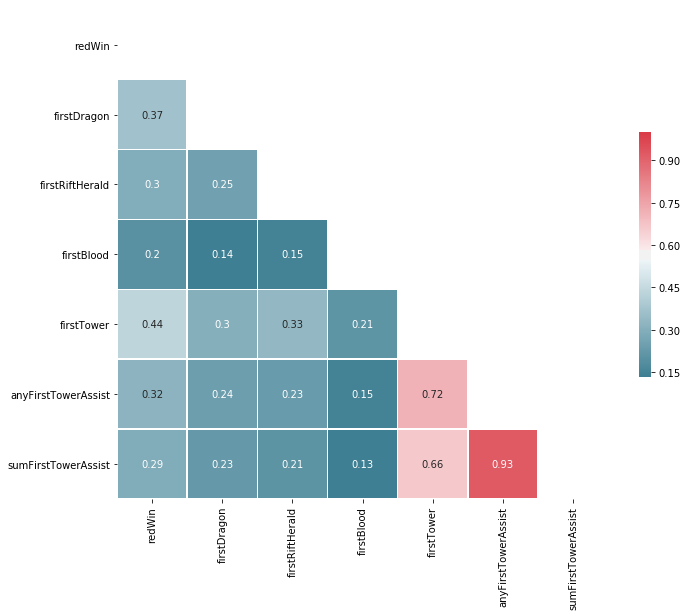

In [187]:
# Compute the correlation matrix
corr = np.zeros((len(features), len(features)), dtype='float32')

for f1_i, (f1, _, _) in enumerate(features):
    for f2_i, (f2, _, _) in enumerate(features):
        corr[f1_i, f2_i] = np.corrcoef(data[f1], data[f2])[0, 1]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sb.heatmap(
    corr, mask=mask, cmap=cmap, #vmax=.3,
    linewidths=.5, cbar_kws={"shrink": .5},
    ax=ax, annot=True,
    xticklabels=tuple(f for f, _, _ in features),
    yticklabels=tuple(f for f, _, _ in features))

In [224]:
# data['sumFirstTowerAssist'] = (((data['sumFirstTowerAssist']*data['anyFirstTowerAssist'])+1)*data['anyFirstTowerAssist'])
# data['sumFirstTowerAssist'] = (1.5 / (1 + np.exp(-data['sumFirstTowerAssist'])))-0.5

In [228]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        'redWin ~ firstDragon + firstRiftHerald + firstBlood + firstTower + anyFirstTowerAssist + sumFirstTowerAssist',
        data,
        family=pm.glm.families.Binomial()
    )
    trace_logistic_model = pm.sample(2000, chains=None, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sumFirstTowerAssist, anyFirstTowerAssist, firstTower, firstBlood, firstRiftHerald, firstDragon, Intercept]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [07:34<00:00,  8.18draws/s]


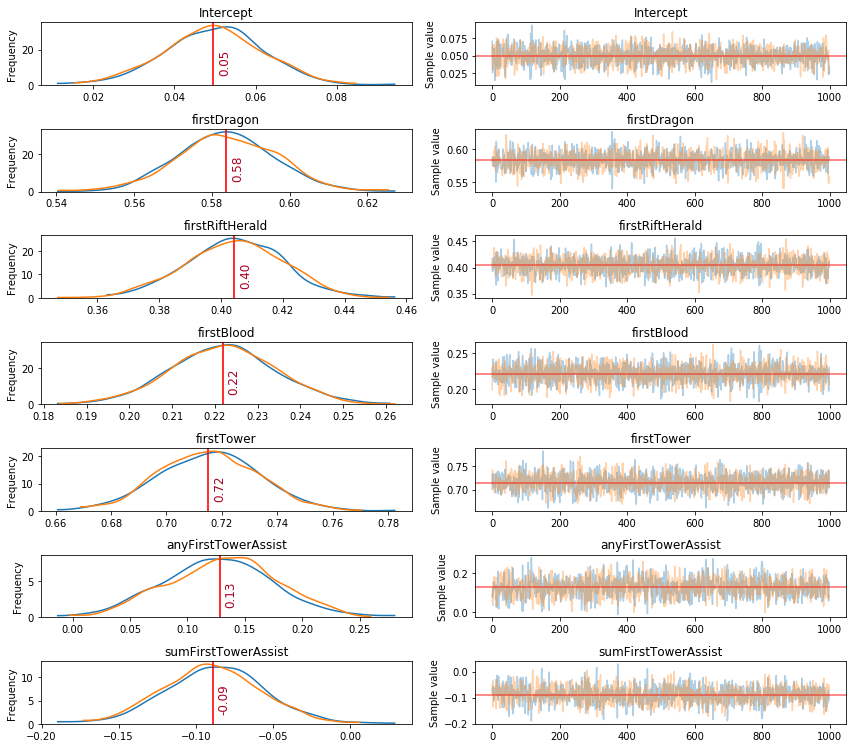

In [229]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

plot_traces(trace_logistic_model, retain=1000)